<a href="https://colab.research.google.com/github/eddiechu888/idioms/blob/main/idioms_llama3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your Hugging Face token: ··········
Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Pad token not found. Setting pad_token to eos_token: <|end_of_text|>
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file found at /content/drive/MyDrive/Colab Notebooks/idioms_data.csv
[{'idiomatic': 'She thought of good ways to break the ice at the company retreat.', 'non_idiomatic': 'She thought of good ways to get people talking at the company retreat.', 'literal': 'She thought of good ways to break the ice to make a cold drink.'}, {'idiomatic': 'Let’s cut to the chase—what exactly are we agreeing to here?', 'non_idiomatic': 'Let’s discuss the main issue—what exactly are we agreeing to here?', 'literal': 'Let’s cut to the chase scene—what exactly are the three characters doing here?'}]
Hooks registered on model layers.

Processing Data Example 1:

Processing 'idiomatic' sentence:
Sentence: She thought of good ways to break the ice at the company retreat.


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Hook 'layer_0': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_1': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_2': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_3': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_4': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_5': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_6': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_7': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_8': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_9': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_10': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_11': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_12': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_13': Capturing Tensor with shape torch.Size([1, 20, 2048])
Hook 'layer_14':

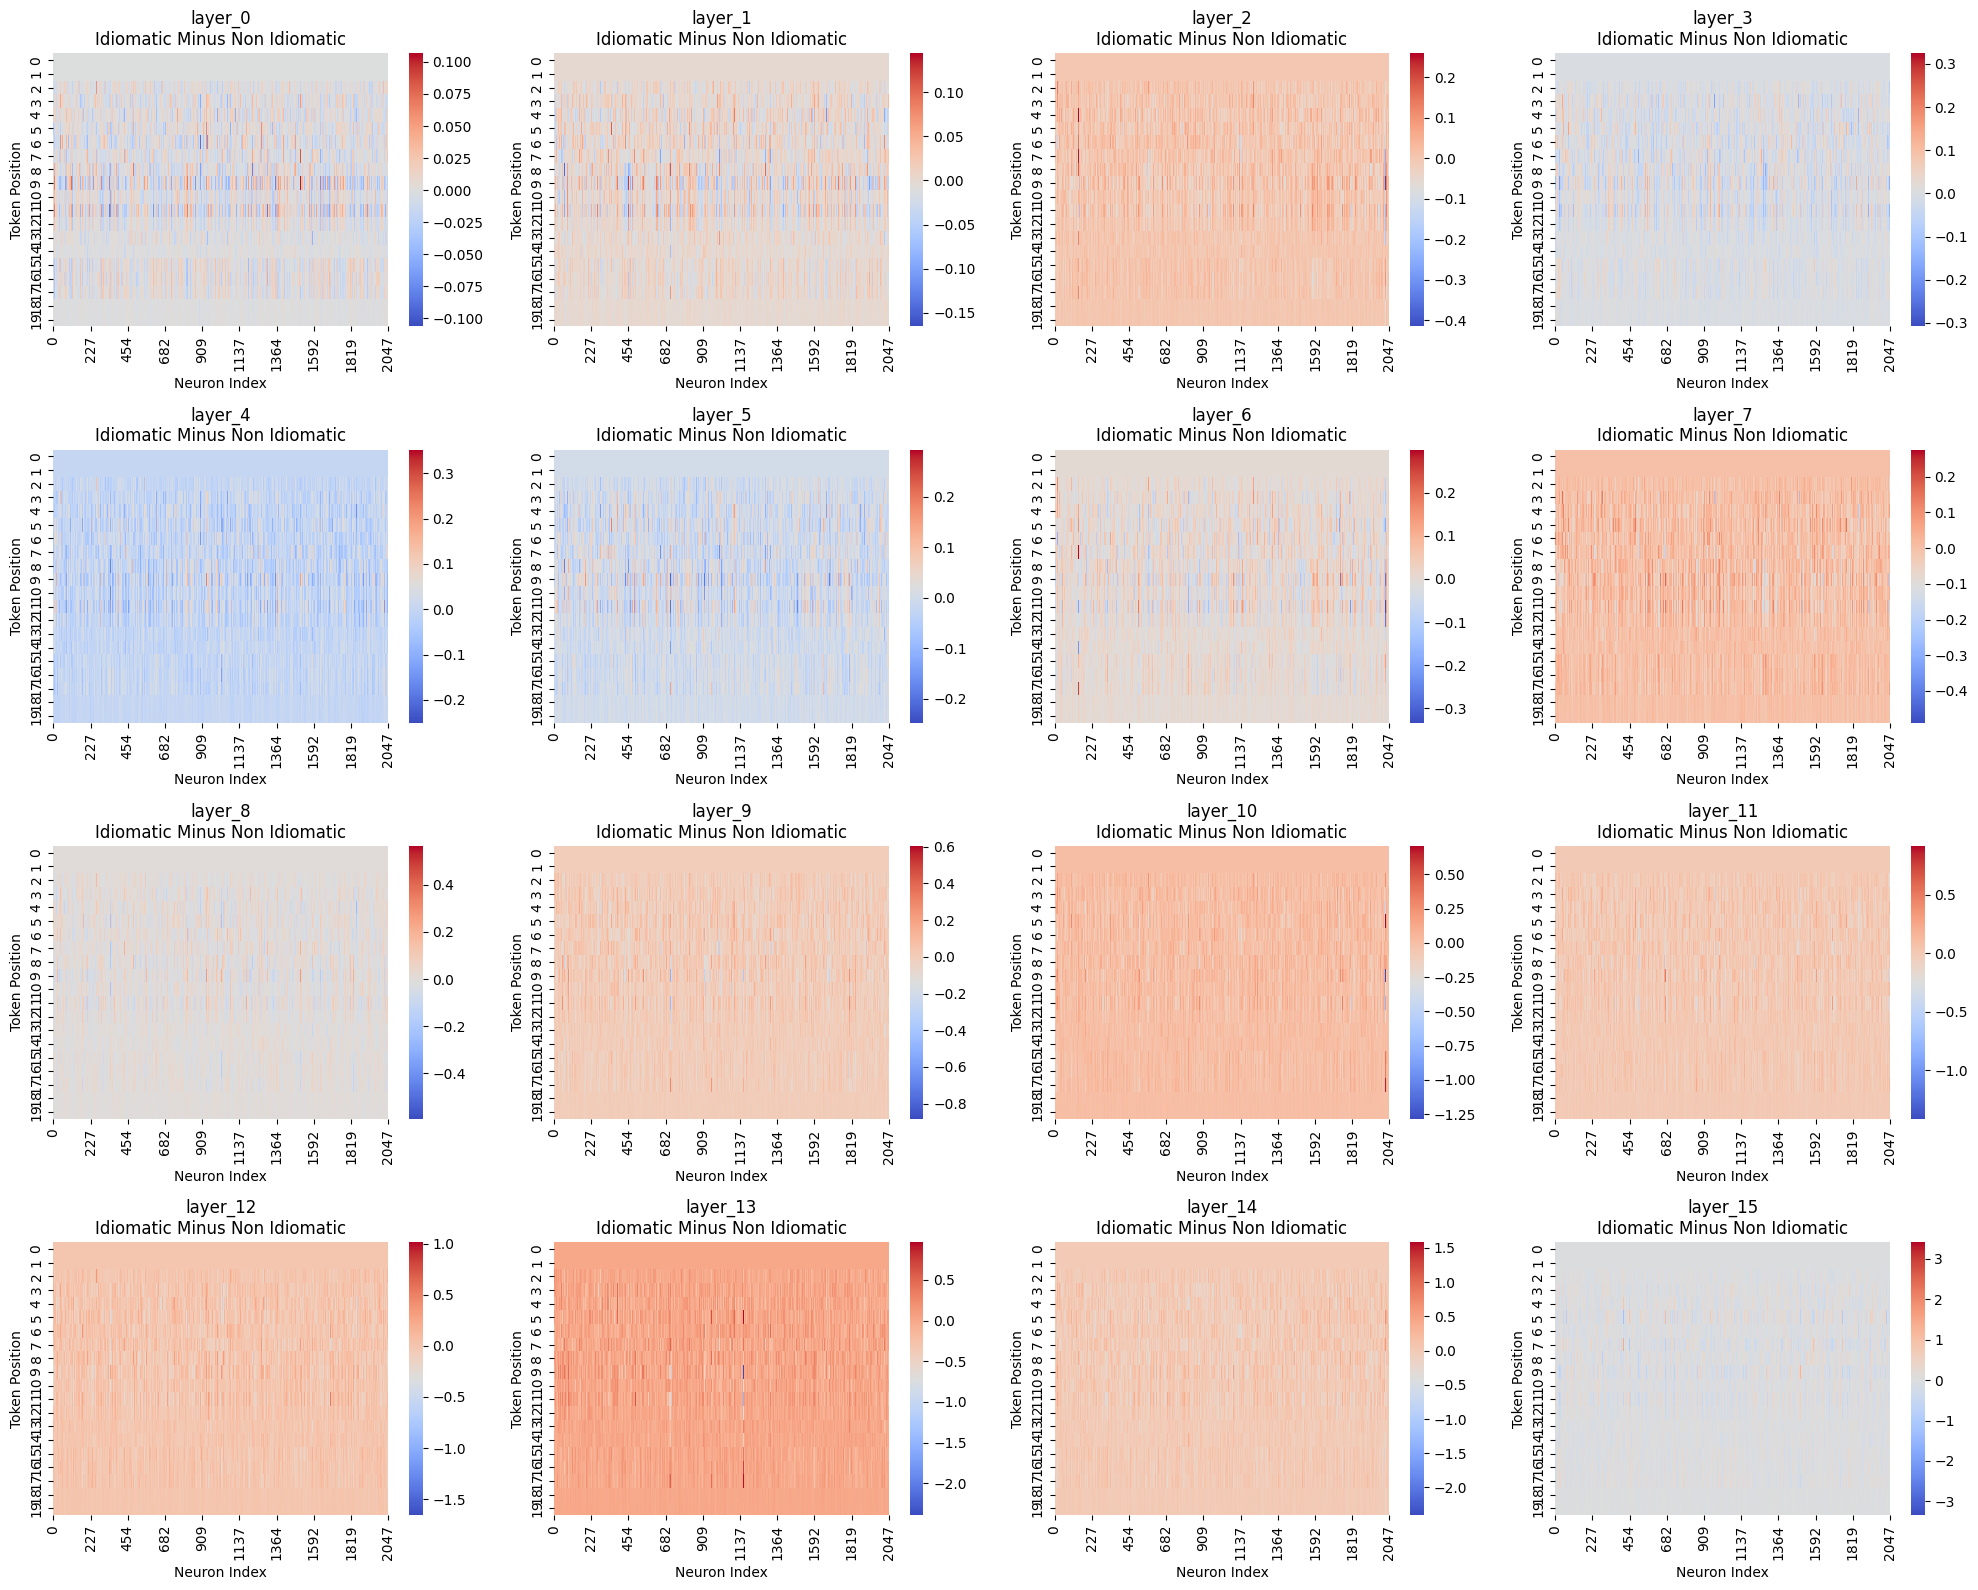

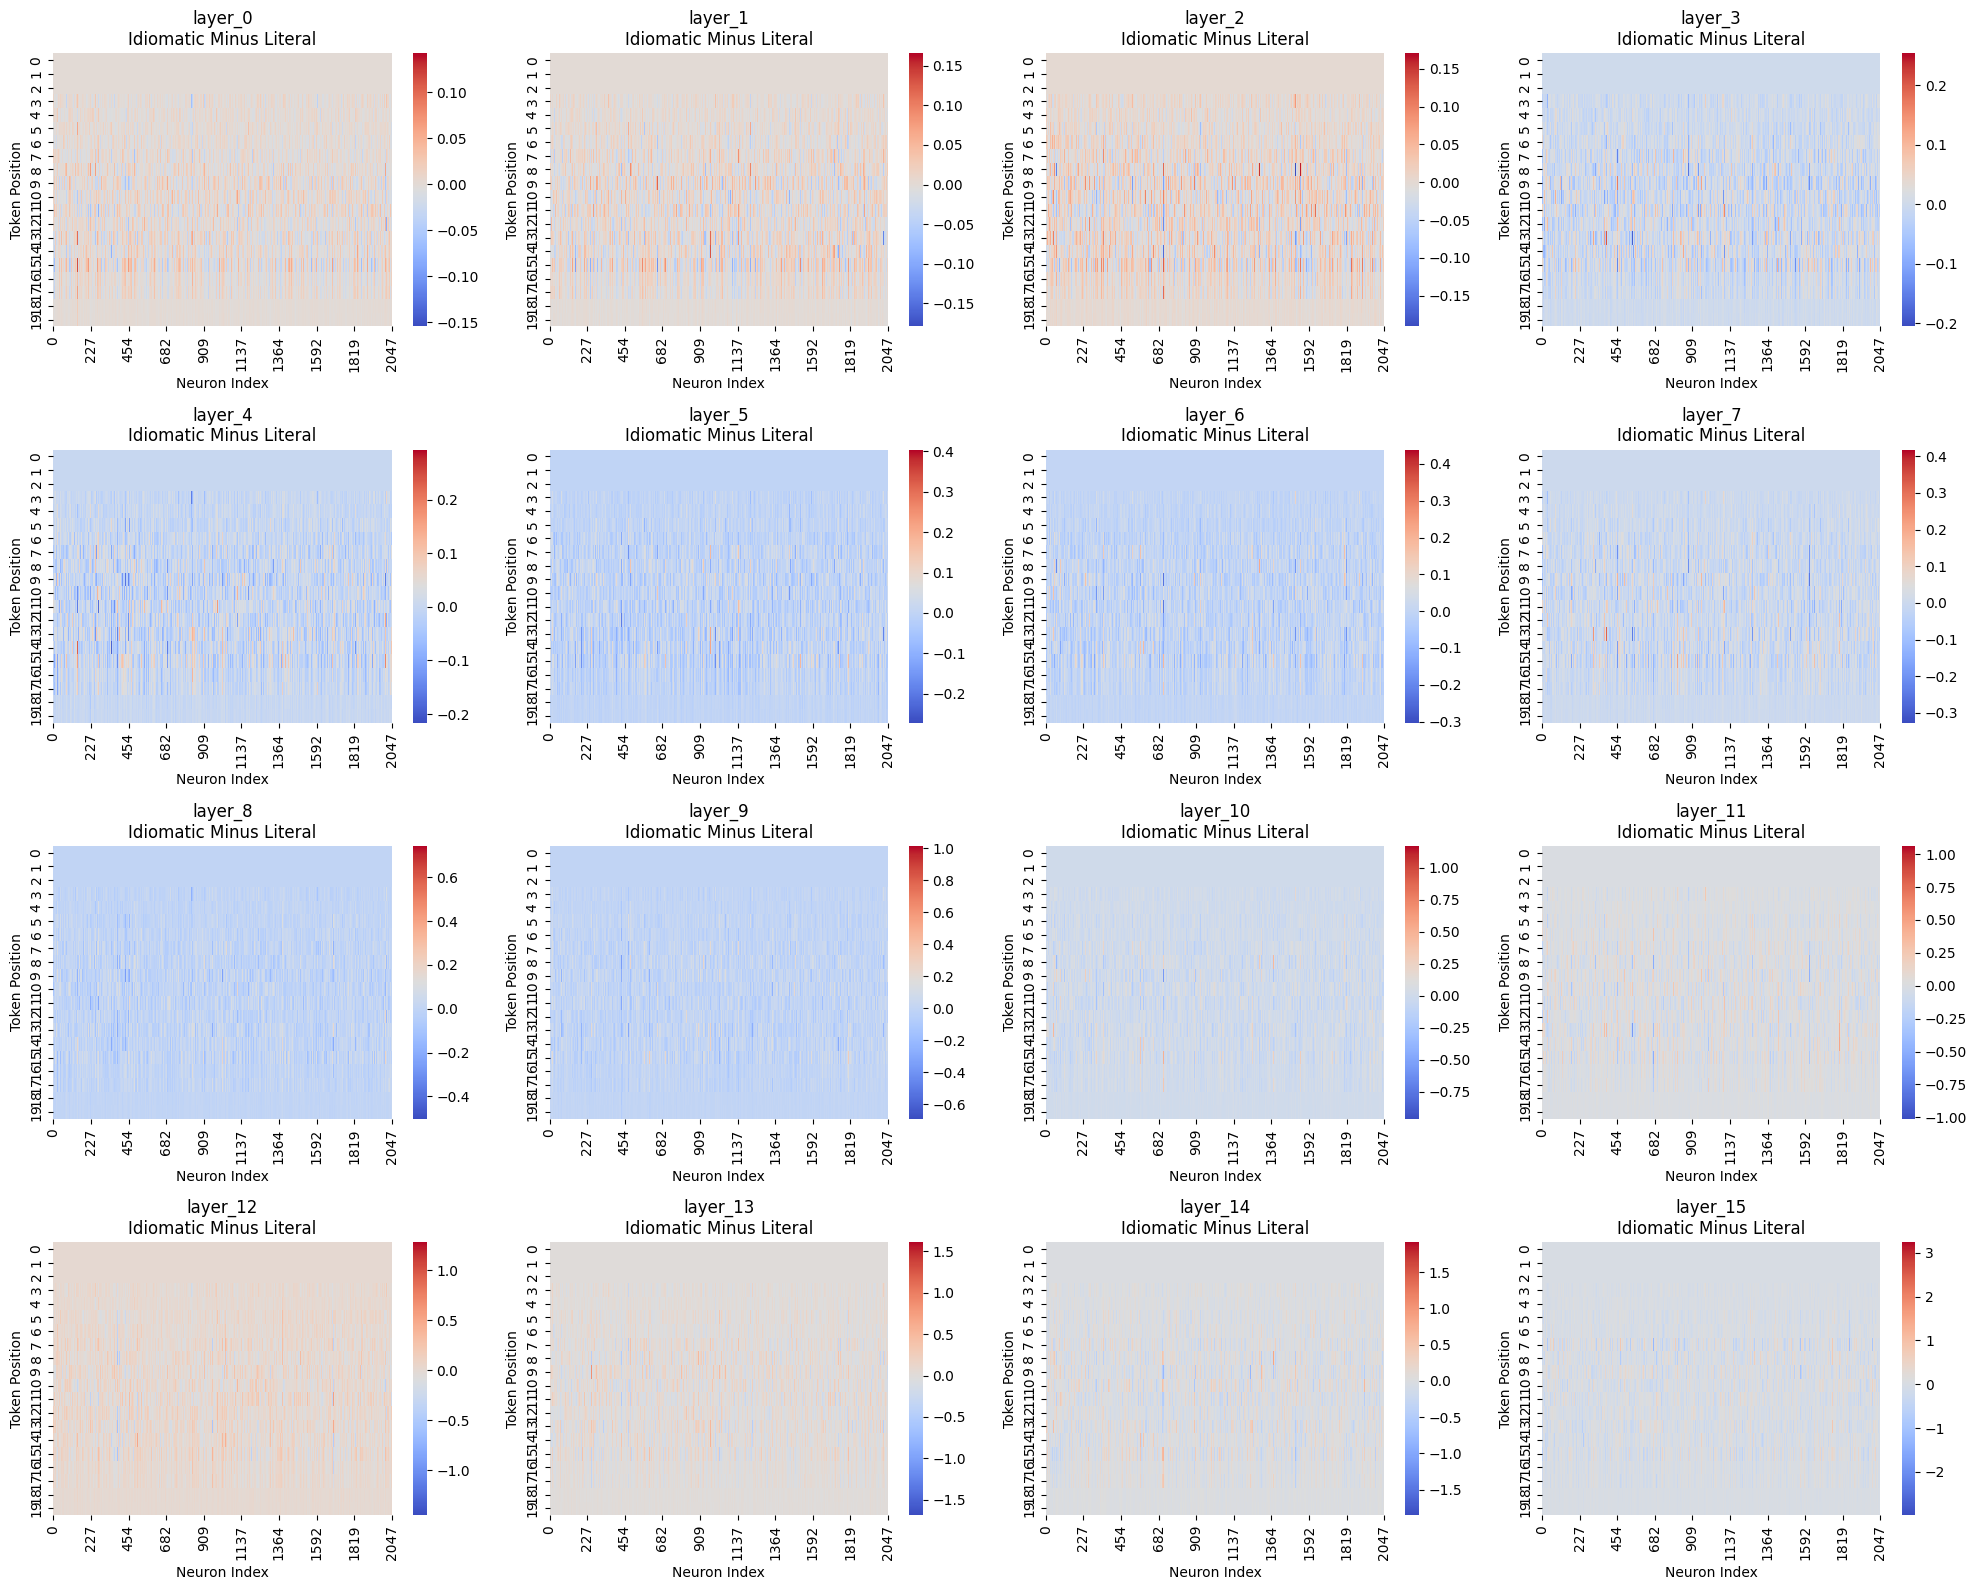

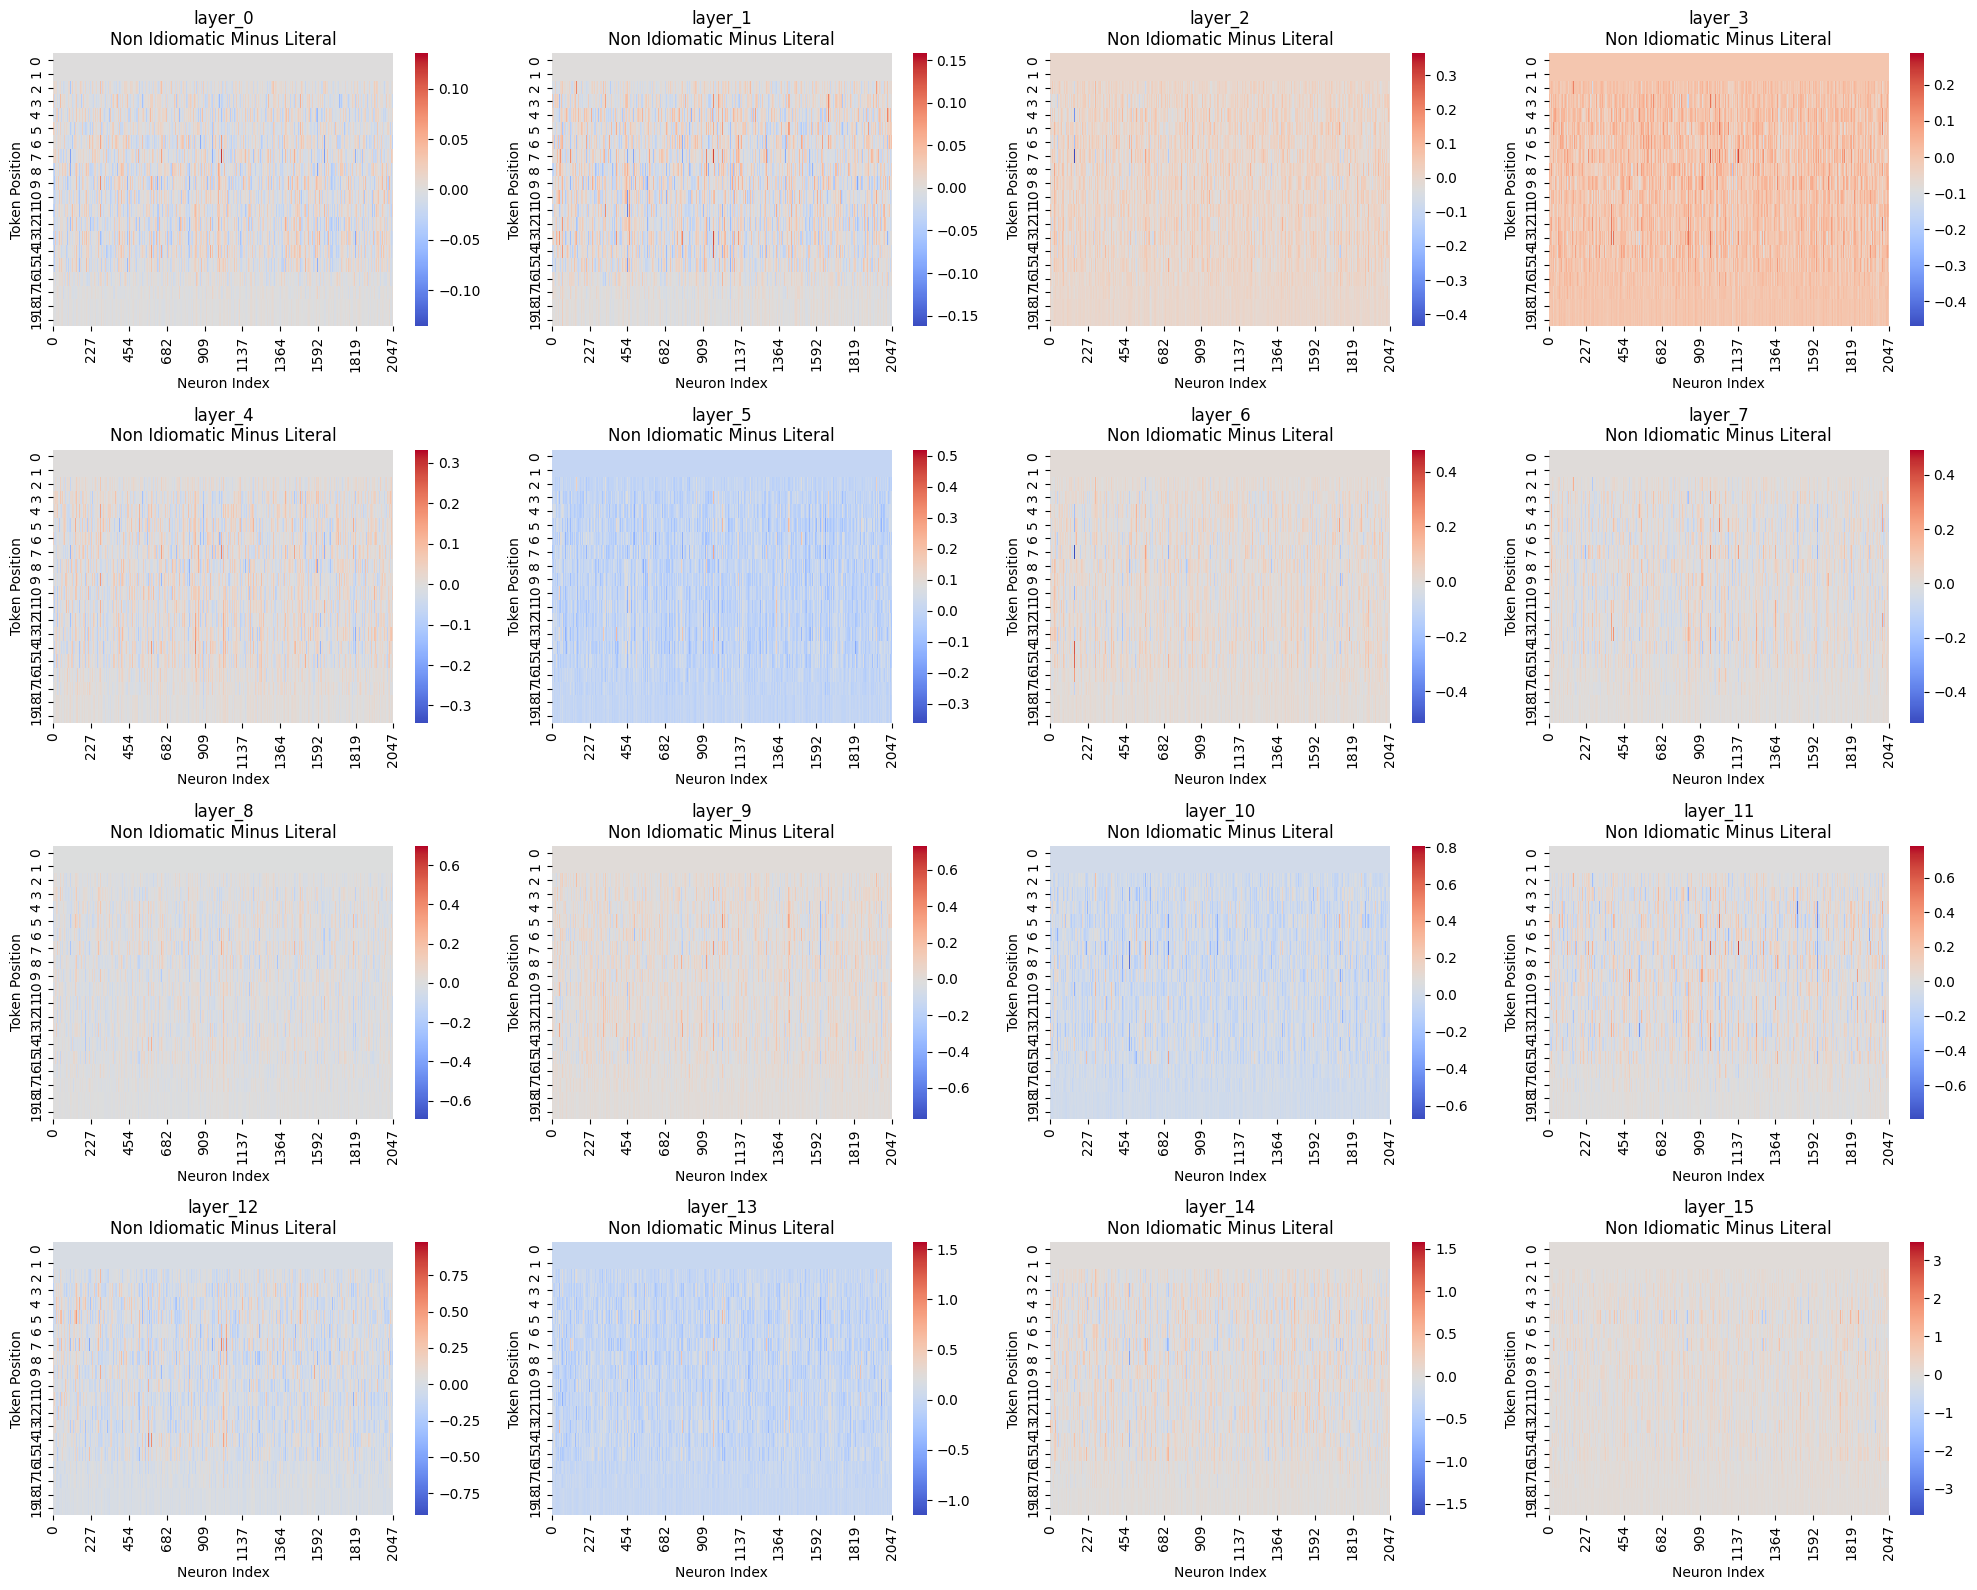

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
import os
import numpy as np
import math

# 1. Setup
hf_token = getpass('Enter your Hugging Face token: ')

if not hf_token:
    raise ValueError("HUGGINGFACE_TOKEN is not set.")

model_name = 'meta-llama/Llama-3.2-1B'  # Replace with your specific model if different

# Check for CUDA and MPS availability and use the best available option
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize tokenizer and model with the Hugging Face token for authentication
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)

# Set pad_token to eos_token if pad_token is not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Pad token not found. Setting pad_token to eos_token: {tokenizer.pad_token}")
else:
    print(f"Using existing pad_token: {tokenizer.pad_token}")

model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=hf_token).to(device)
model.eval()  # Set model to evaluation mode

# 2. Define Multiple Data Examples
data_examples = [
    {
        "idiomatic": "She thought of good ways to break the ice at the company retreat.",
        "non_idiomatic": "She thought of good ways to get people talking at the company retreat.",
        "literal": "She thought of good ways to break the ice to make a cold drink."
    },
    {
        "idiomatic": "Let’s cut to the chase—what exactly are we agreeing to here?",
        "non_idiomatic": "Let’s discuss the main issue—what exactly are we agreeing to here?",
        "literal": "Let’s cut to the chase scene—what exactly are the three characters doing here?"
    },
    {
        "idiomatic": "You really hit the nail on the head with that suggestion.",
        "non_idiomatic": "You really hit the nail on the head nailing that chair leg.",
        "literal": "You were exactly right with that suggestion."
    }
]

from google.colab import drive
import os
import csv

def load_data_from_csv(file_path):
    data_examples = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data_examples.append({
                "idiomatic": row['idiomatic'],
                "non_idiomatic": row['non_idiomatic'],
                "literal": row['literal']
            })
    return data_examples

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your CSV file in Google Drive
# Adjust the path according to where you place your file in Drive
csv_path = '/content/drive/MyDrive/Colab Notebooks/idioms_data.csv'

# Check if the file exists
if os.path.exists(csv_path):
    print(f"CSV file found at {csv_path}")
else:
    print(f"CSV file not found at {csv_path}. Please check the path.")

# Now you can use this path in your load_data_from_csv function
data_examples = load_data_from_csv(csv_path)

# You can verify the contents of data_examples
print(data_examples[:2])  # Print first two entries

# 3. Define Hook for Activations
activations = defaultdict(list)

def get_activation(name):
    def hook(model, input, output):
        # If output is a tuple, extract the first element (hidden states)
        if isinstance(output, tuple):
            output = output[0]

        # If output is a list, extract the first element
        if isinstance(output, list):
            output = output[0]

        # Check if the output is a Tensor
        if isinstance(output, torch.Tensor):
            # Assuming output shape: [batch_size, seq_length, hidden_size]
            print(f"Hook '{name}': Capturing Tensor with shape {output.shape}")
            activations[name].append(output.detach().cpu())
        else:
            print(f"Hook '{name}': Output is of type {type(output)}, skipping.")
    return hook

# Register hooks on all transformer layers
try:
    # Assuming the model's transformer layers are accessible via model.model.layers
    for i, layer in enumerate(model.model.layers):
        layer_name = f'layer_{i}'
        layer.register_forward_hook(get_activation(layer_name))
except AttributeError:
    print("Error: 'model.model.layers' attribute not found. Inspecting model structure:")
    print(model)
    raise

print("Hooks registered on model layers.")

# 4. Function to Process a Sentence and Capture Activations
def process_sentence(sentence, max_length=20):
    encoded_input = tokenizer(
        sentence,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    ).to(device)
    with torch.no_grad():
        model(**encoded_input)
    # After forward pass, activations are populated via hooks
    return

# 5. Process Each Data Example and Capture Activations
conditions = ['idiomatic', 'non_idiomatic', 'literal']
activations_per_condition = {
    "idiomatic": defaultdict(list),
    "non_idiomatic": defaultdict(list),
    "literal": defaultdict(list)
}

for idx, data in enumerate(data_examples):
    print(f"\nProcessing Data Example {idx + 1}:")
    for condition in conditions:
        sentence = data[condition]
        print(f"\nProcessing '{condition}' sentence:")
        print(f"Sentence: {sentence}")

        # Clear previous activations
        activations.clear()

        # Process the sentence with fixed max_length
        process_sentence(sentence, max_length=20)

        # Store activations using 'extend' to avoid nested lists
        for layer, acts in activations.items():
            activations_per_condition[condition][layer].extend(acts)

        print(f"Activations captured for '{condition}' condition.")

# 6. Compute Average Activations Across All Data Examples
def compute_average_activation(activations_per_condition):
    """
    Computes the average activation per condition and layer across all data examples.

    Parameters:
    - activations_per_condition (dict): Nested dictionary with activations per condition and layer.

    Returns:
    - average_activations (dict): Nested dictionary with average activations per condition and layer.
    """
    average_activations = {
        "idiomatic": {},
        "non_idiomatic": {},
        "literal": {}
    }

    for condition, layers_dict in activations_per_condition.items():
        for layer, acts in layers_dict.items():
            if not acts:
                print(f"No activations found for condition '{condition}', layer '{layer}'. Skipping.")
                continue
            try:
                # Stack all activations for the layer across data examples
                stacked = torch.cat(acts, dim=0)  # Shape: [num_examples, seq_length, hidden_size]
                # Compute the mean across the data example dimension
                average = stacked.mean(dim=0)  # Shape: [seq_length, hidden_size]
                average_activations[condition][layer] = average
            except Exception as e:
                print(f"Error computing average for condition '{condition}', layer '{layer}': {e}")

    return average_activations

average_activations = compute_average_activation(activations_per_condition)

# 7. Calculate Activation Differences Between Conditions
def compute_activation_differences(average_activations):
    """
    Computes activation differences between conditions.

    Parameters:
    - average_activations (dict): Nested dictionary with average activations per condition and layer.

    Returns:
    - activation_differences (dict): Nested dictionary with activation differences between conditions.
    """
    activation_differences = {
        "idiomatic_minus_non_idiomatic": {},
        "idiomatic_minus_literal": {},
        "non_idiomatic_minus_literal": {}
    }

    # Collect all layers
    layers = set()
    for condition in average_activations:
        layers.update(average_activations[condition].keys())
    layers = sorted(layers, key=lambda x: int(x.split('_')[1]))  # Sort layers numerically

    for layer in layers:
        try:
            idiomatic = average_activations["idiomatic"][layer]
            non_idiomatic = average_activations["non_idiomatic"][layer]
            literal = average_activations["literal"][layer]

            activation_differences["idiomatic_minus_non_idiomatic"][layer] = idiomatic - non_idiomatic
            activation_differences["idiomatic_minus_literal"][layer] = idiomatic - literal
            activation_differences["non_idiomatic_minus_literal"][layer] = non_idiomatic - literal
        except KeyError as e:
            print(f"Missing data for layer '{layer}': {e}")
        except Exception as e:
            print(f"Error computing differences for layer '{layer}': {e}")

    return activation_differences

activation_differences = compute_activation_differences(average_activations)

# 8. Visualize the Aggregated Activation Differences Across All Layers
def plot_all_activation_differences(activation_differences, comparison_key, plot_type='full', neuron_start=0, neuron_end=100):
    """
    Plots activation differences for all layers in a grid of subplots, including an average row.

    Parameters:
    - activation_differences (dict): Nested dictionary with activation differences.
    - comparison_key (str): The key indicating which comparison to plot (e.g., 'idiomatic_minus_non_idiomatic').
    - plot_type (str): Type of plot ('full', 'average', 'subset').
    - neuron_start (int): Starting index for neuron subset (used if plot_type='subset').
    - neuron_end (int): Ending index for neuron subset (used if plot_type='subset').
    """
    if comparison_key not in activation_differences:
        print(f"Comparison key '{comparison_key}' not found in activation differences.")
        return

    differences = activation_differences[comparison_key]
    layers = sorted(differences.keys(), key=lambda x: int(x.split('_')[1]))
    num_layers = len(layers)

    # Determine grid size (e.g., 4x4 for 16 layers)
    grid_cols = math.ceil(math.sqrt(num_layers))
    grid_rows = math.ceil(num_layers / grid_cols)

    plt.figure(figsize=(grid_cols * 5, grid_rows * 5))  # Increased height to accommodate average row

    for idx, layer in enumerate(layers):
        difference = differences[layer]
        difference_np = difference.numpy()

        # Calculate average across token positions
        avg_across_positions = np.mean(difference_np, axis=0)

        # Create a new array with the average row appended
        difference_with_avg = np.vstack([difference_np, avg_across_positions])

        ax = plt.subplot(grid_rows, grid_cols, idx + 1)

        if plot_type == 'full':
            sns.heatmap(difference_with_avg, cmap='coolwarm', ax=ax)
        elif plot_type == 'average':
            # Average across neurons for each token
            average_diff = np.mean(difference_np, axis=1)
            average_diff = np.append(average_diff, np.mean(average_diff))  # Add overall average
            sns.heatmap(average_diff.reshape(-1, 1), cmap='coolwarm', ax=ax, cbar=True)
        elif plot_type == 'subset':
            # Plot a subset of neurons
            subset_diff = difference_with_avg[:, neuron_start:neuron_end]
            sns.heatmap(subset_diff, cmap='coolwarm', ax=ax)
        else:
            print(f"Invalid plot_type '{plot_type}'. Choose from 'full', 'average', or 'subset'.")
            return

        ax.set_title(f'{layer}\n{comparison_key.replace("_", " ").title()}')
        ax.set_xlabel('Neuron Index')
        ax.set_ylabel('Token Position')

        # Adjust tick labels for clarity
        num_tokens = difference_np.shape[0]
        ax.set_yticks(np.arange(0.5, num_tokens + 1.5, 1))
        ax.set_yticklabels(list(range(num_tokens)) + ['Avg'])

        if plot_type != 'average':
            num_neurons = difference_with_avg.shape[1]
            ax.set_xticks(np.linspace(0.5, num_neurons, num=10))
            ax.set_xticklabels(np.linspace(0, num_neurons-1, num=10, dtype=int))
        else:
            ax.set_xticks([])

        # Add a horizontal line to separate the average row
        ax.axhline(y=num_tokens, color='black', linewidth=2)

    plt.tight_layout()
    plt.show()

# Example Usage: Plotting 'Idiomatic - Non-idiomatic' Activation Differences
plot_all_activation_differences(
    activation_differences,
    comparison_key='idiomatic_minus_non_idiomatic',
    plot_type='full'  # Change to 'average' or 'subset' as needed
)

# Similarly, plot other comparisons:
# Idiomatic - Literal
plot_all_activation_differences(
    activation_differences,
    comparison_key='idiomatic_minus_literal',
    plot_type='full'
)

# Non-idiomatic - Literal
plot_all_activation_differences(
    activation_differences,
    comparison_key='non_idiomatic_minus_literal',
    plot_type='full'
)